In [1]:
import tensorflow as tf
import pandas as pd
import math
import numpy as np

2025-01-22 08:38:51.164654: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-22 08:38:51.326548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737531531.393331    4937 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737531531.414539    4937 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-22 08:38:51.560335: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
df_train = pd.read_csv("dataset/train.csv", sep = ";")
df_test = pd.read_csv("dataset/test.csv", sep = ";")
df_eval = pd.read_csv("dataset/evaluation.csv", sep = ";")

In [3]:
all_titles = pd.concat([df_train, df_eval, df_test]).dropna()["title"].tolist()

In [4]:
filter_vocab = set(sorted([
    ' ', '!', '"', '#', '$',
    '%','&', "'", '(', ')',
    '*', '+', ',', '-','.',
    '/', '0', '1', '2', '3',
    '4', '5', '6', '7', '8',
    '9', ':', ';', '=', '?',
    '@', 'A', 'B', 'C', 'D',
    'E', 'F', 'G', 'H', 'I',
    'J', 'K', 'L', 'M', 'N',
    'O', 'P', 'Q', 'R', 'S',
    'T', 'U', 'V', 'W', 'X',
    'Y', 'Z', '[', ']', '_',
    'a', 'b', 'c', 'd', 'e',
    'f', 'g', 'h', 'i', 'j',
    'k', 'l', 'm', 'n', 'o',
    'p', 'q', 'r', 's', 't',
    'u', 'v', 'w', 'x', 'y',
    'z', '{', '}', '“', '”',
    "<pad>"
]))

In [5]:
VOCAB_SIZE: int = len(filter_vocab)
SEQ_SIZE: int = 125

In [6]:
def filter_chars(text: str) -> str:
    global filter_vocab
    return "".join([c if c in filter_vocab else "" for c in text])

In [7]:
filtered_titles = [filter_chars(title) for title in all_titles]

In [8]:
loaded = np.load('encoder.npz')
one_hot_encoder = {key: loaded[key] for key in loaded}

In [9]:
def split_encode(text: str) -> list[list[int]]:
    global one_hot_encoder
    global SEQ_SIZE
    encoded = [one_hot_encoder[x] for x in [*text][:SEQ_SIZE]]
    padded = encoded + [one_hot_encoder["<pad>"]] * (SEQ_SIZE - len(encoded))
    return padded

In [10]:
data = np.array([split_encode(text) for text in filtered_titles])

In [11]:
BATCH_SIZE = 8

In [12]:
X = data[:, :-1, :] 
y = data[:, 1:, :]  

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.shuffle(512).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

W0000 00:00:1737531535.647207    4937 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [14]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(SEQ_SIZE - 1, VOCAB_SIZE)),
    tf.keras.layers.LSTM(256, return_sequences=True, dropout=0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(VOCAB_SIZE, activation='softmax')
])

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [16]:
history = model.fit(dataset, epochs=20)

Epoch 1/20
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 179s 35ms/step - loss: 1.5715
Epoch 2/20
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 178s 35ms/step - loss: 1.2086
Epoch 3/20
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 177s 35ms/step - loss: 1.1260
Epoch 4/20
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 177s 35ms/step - loss: 1.0812
Epoch 5/20
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 190s 37ms/step - loss: 1.0525
Epoch 6/20
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 216s 43ms/step - loss: 1.0357
Epoch 7/20
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 220s 43ms/step - loss: 1.0181
Epoch 8/20
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 219s 43ms/step - loss: 1.0104
Epoch 9/20
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 218s 43ms/step - loss: 0.9992
Epoch 10/20
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 220s 43ms/step - loss: 0.9912
Epoch 11/20
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 218s 43ms/step - loss: 0.9845
Epoch 12/20
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 218s 43ms/step - loss: 0.9783
Epoch 13/20
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 199s 39ms/step - loss: 0.9737
Epoch 14/20
5074/5074 ━━━━━━━━━━━━━━━━━━━━ 203s 40ms/step - 

In [17]:
def encode(src: str) -> np.ndarray:
    dst = []
    for letter in [*src]:
        dst.append(one_hot_encoder[letter])
    return np.array(dst)

In [18]:
def decode(src: np.ndarray) -> str:
    dst = ""
    for coded in src:
        for key, val in one_hot_encoder.items():
            if (coded == val).all():
                dst += key
                break
    return dst

In [19]:
input_seq = encode("Breaking news: ")

In [20]:
def generate_sequence(model, start_sequence, seq_length, decode):
    current_input = np.copy(start_sequence)  
    generated_sequence = decode(current_input)  
    for _ in range(seq_length):
        predictions = model.predict(current_input[np.newaxis, ...], verbose=0) 
        
        next_char_idx = np.argmax(predictions[0, -1, :])
        
        next_char_onehot = np.zeros_like(current_input[0])
        next_char_onehot[next_char_idx] = 1

        current_input = np.roll(current_input, shift=-1, axis=0)
        current_input[-1] = next_char_onehot  
        
        generated_sequence += decode(next_char_onehot[np.newaxis, ...])
    
    return generated_sequence

In [21]:
generated_text = generate_sequence(model, input_seq, SEQ_SIZE, decode)
print(generated_text)

Breaking news: Trump says he will not see to stand in the state of the president Obama says he Was the U.S. Senate panel to start the state 


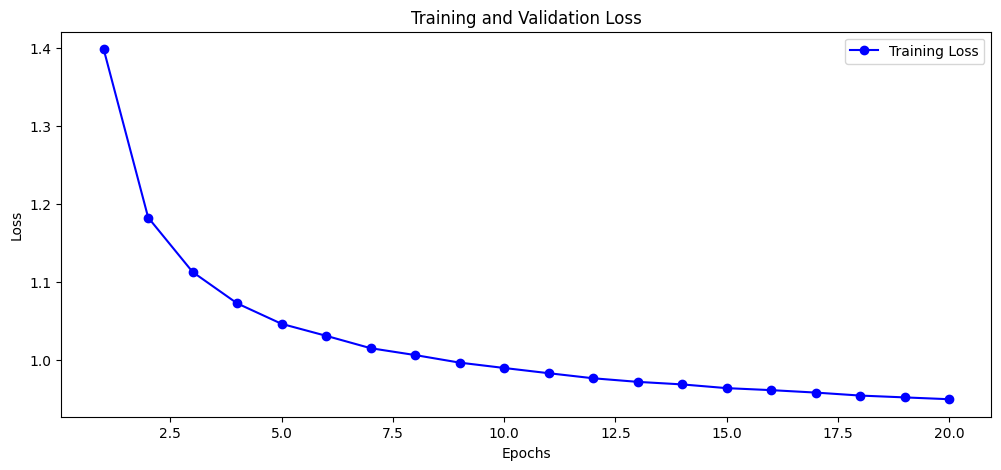

In [22]:
import matplotlib.pyplot as plt

history_dict = history.history

loss = history_dict['loss']  
epochs = range(1, len(loss) + 1)  

val_loss = history_dict.get('val_loss', None)
accuracy = history_dict.get('accuracy', None)
val_accuracy = history_dict.get('val_accuracy', None)

plt.figure(figsize=(12, 5))

plt.plot(epochs, loss, 'bo-', label='Training Loss') 
if val_loss:
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss') 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [23]:
model.save("generator_dropout_complex.keras")